In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import tarfile
import os


import cv2
from PIL import Image
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import random
import argparse
import matplotlib.animation as animation
import torch.nn.utils.spectral_norm as spectral_norm
from ignite.metrics import FID, InceptionScore
import PIL.Image as Image


from IPython.display import HTML

import torch.optim as optim


from ignite.engine import Engine, Events
import ignite.distributed as idist

In [2]:
# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  3602


In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")
torch.cuda.device_count()
print(torch.version.cuda)

No GPU available. Training will run on CPU.
None


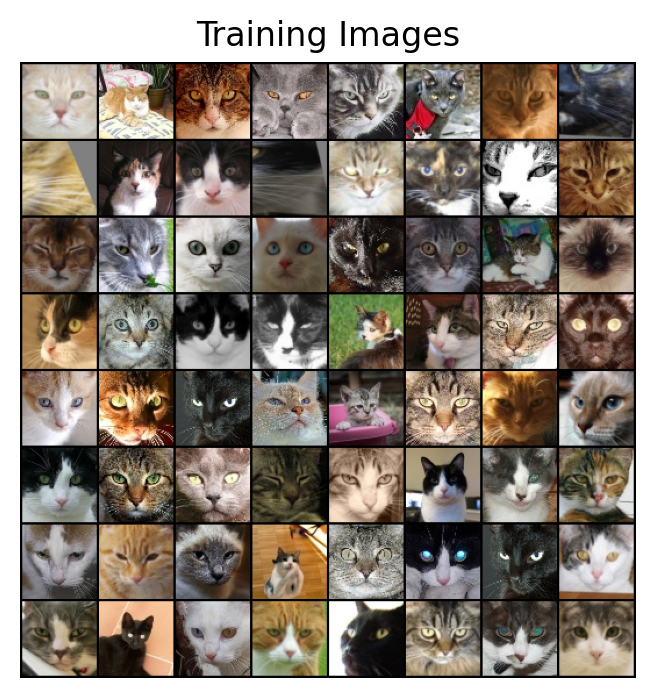

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np

dataroot = 'data_cat_imGen\Cat_faces'

image_size = 64

# Batch size during training
batch_size = 128

# Number of workers for dataloader
workers = 2

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))

# Calculate the number of images for training and testing
num_total = len(dataset)
num_test = 128  # Take only 128 images for testing
num_train = num_total - num_test  # Remaining images for training

# Split the dataset into training and testing subsets
train_dataset, test_dataset = data.random_split(dataset, [num_train, num_test])

# Create the data loaders
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, num_workers=workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=num_test,
                                              shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


In [5]:
# Fetch a sample batch from the dataloader
sample_batch = next(iter(dataloader))

# Get the image tensors from the batch
images = sample_batch[0]  # Assuming image data is in the first index of the tuple

# Check the min and max values
min_val = images.min().item()
max_val = images.max().item()

print("Min pixel value:", min_val)
print("Max pixel value:", max_val)

Min pixel value: 0.0
Max pixel value: 1.0


In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Set the number of hidden units
        self.num_hidden = 64

        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # input size: (3, 64, 64), output size: (16, 32, 32)
            nn.ReLU(),  # apply the ReLU activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # input size: (16, 32, 32), output size: (32, 16, 16)
            nn.ReLU(),  # apply the ReLU activation function
        )

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # input size: (32, 16, 16), output size: (16, 32, 32)
            nn.ReLU(),  # apply the ReLU activation function
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # input size: (16, 32, 32), output size: (3, 64, 64)
            nn.Sigmoid(),  # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded

In [7]:
# learning rate
learning_rate = 0.001

# batch size
batch_size = 128

# number of epochs
num_epochs = 30

# number of hidden units
num_hidden = 64

import torch.optim as optim

# Create the autoencoder model and optimizer
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss()

# Set the device to GPU if available, otherwise use CPU
model.to(device)


AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [8]:
import torch
import torch.nn as nn

class VAE(AutoEncoder):
    def __init__(self, input_channels, imsize, batchsize):
        super().__init__()
        self.input_channels = input_channels
        self.imsize = imsize
        self.flatten_size = input_channels * imsize * imsize
        self.batchsize = batchsize
        self.lattent_dim_divider = 64
        # Calculate output size after flattening
        #self.num_hidden = self.batchsize * (imsize // 8) * (imsize // 8)

        # Adjust num_hidden
        self.num_hidden = self.batchsize * (imsize // self.lattent_dim_divider) * (imsize // self.lattent_dim_divider)
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Additional layer
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1),  # Additional layer
            nn.ReLU(),
            nn.Conv2d(256, self.batchsize, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )


        # Add more layers to decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # Additional layer
            nn.ReLU(),
            nn.Linear(256, 256),  # Additional layer
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_hidden),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(self.batchsize, 256, kernel_size=4, stride=2, padding=1),  # Match with encoder
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  # Match with encoder
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Match with encoder
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Match with encoder
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Match with encoder
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Sigmoid activation to ensure outputs are in [0, 1]
        )

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        reparam = mu + eps * std

        return reparam

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        decoded = decoded.view(-1, self.batchsize, self.imsize // self.lattent_dim_divider, self.imsize // self.lattent_dim_divider)
        decoded = self.decoder_conv(decoded)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            # Pass the noise through the decoder to generate samples
            decoded = self.decoder(z)
            decoded = decoded.view(-1, self.batchsize, self.imsize // self.lattent_dim_divider, self.imsize // self.lattent_dim_divider)
            samples = self.decoder_conv(decoded)
        # Return the generated samples
        return samples
    def generate_images(self, num_generated_images):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_generated_images, self.num_hidden).to(device)
            z = z + z * z # reproduce the same calculation as the reparametrization
            # Pass the noise through the decoder to generate samples
            decoded = self.decoder(z)
            decoded = decoded.view(-1, self.batchsize, self.imsize // self.lattent_dim_divider, self.imsize // self.lattent_dim_divider)
            generated_images = self.decoder_conv(decoded)
        # Return the generated samples
        return generated_images


In [9]:
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        fake_batch = model.generate_images(128)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [26]:
# Convert the training data to PyTorch tensors
#X_train = torch.from_numpy(X_train).to(device)

from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=192, normalize = True,reset_real_features = False)
fid.set_dtype(torch.float64)
real_images = next(iter(test_dataloader))[0]
fid.update(real_images, real=True)

fid_values = []
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])
is_values = []

num_epochs = 50
# Create the autoencoder model and optimizer
model = VAE(input_channels = 3, imsize = 64, batchsize = 256)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss(reduction="sum")
criterion = nn.BCELoss(reduction='sum')
beta = 1
# Set the device to GPU if available, otherwise use CPU
model.to(device)

# Create a DataLoader to handle batching of the training data
loss_list = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    
    ## Create the dataloader and reshuffles every epoch
    #data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    #                                     shuffle=True, num_workers=workers)
    
    for i, data in enumerate(dataloader, 0):
        # Get a batch of training data and move it to the device
        data_gpu = data[0].to(device)

        # Forward pass
        encoded, decoded, mu, log_var = model(data_gpu)

        # Compute the loss and perform backpropagation
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        MSE = criterion(decoded, data_gpu)
        beta = 2 if epoch > 10 else 0
        loss =  MSE + beta*KLD

        # Zero the gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item()

    evaluator = Engine(evaluation_step)
    is_metric.attach(evaluator, "is")
    
    
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    is_score = metrics['is']
    is_values.append(is_score)

    generated_images = model.generate_images(128).cpu().detach()
    fid.update(generated_images, real=False)
    fid_values.append(fid.compute())
    fid.reset()
    
    # Print the epoch loss
    epoch_loss = total_loss / len(dataloader.dataset) * len(data_gpu)
    loss_list.append(epoch_loss)
    print(
        "Epoch {}/{}: loss={:.4f}, KL_loss={:.4f}, MSE_loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss,beta*KLD,MSE)
    )

Epoch 1/50: loss=151616.1146, KL_loss=0.0000, MSE_loss=151990.9062
Epoch 2/50: loss=146271.9612, KL_loss=0.0000, MSE_loss=141007.5312
Epoch 3/50: loss=141853.6929, KL_loss=0.0000, MSE_loss=139902.5000
Epoch 4/50: loss=140993.1813, KL_loss=0.0000, MSE_loss=137026.8125
Epoch 5/50: loss=139649.8996, KL_loss=0.0000, MSE_loss=147412.4844
Epoch 6/50: loss=139514.4200, KL_loss=0.0000, MSE_loss=143816.5312
Epoch 7/50: loss=139411.1965, KL_loss=0.0000, MSE_loss=138451.2500
Epoch 8/50: loss=139276.6135, KL_loss=0.0000, MSE_loss=142717.8750
Epoch 9/50: loss=138609.6346, KL_loss=0.0000, MSE_loss=142353.8750
Epoch 10/50: loss=137509.3637, KL_loss=0.0000, MSE_loss=130796.7969
Epoch 11/50: loss=137196.9489, KL_loss=0.0000, MSE_loss=137896.0000
Epoch 12/50: loss=149118.8023, KL_loss=898.0529, MSE_loss=138941.1875
Epoch 13/50: loss=143552.9849, KL_loss=774.1746, MSE_loss=142853.4531
Epoch 14/50: loss=143092.0645, KL_loss=912.2152, MSE_loss=148201.5625
Epoch 15/50: loss=141359.9851, KL_loss=837.5715, MS

Text(0.5, 1.0, 'Loss over epochs')

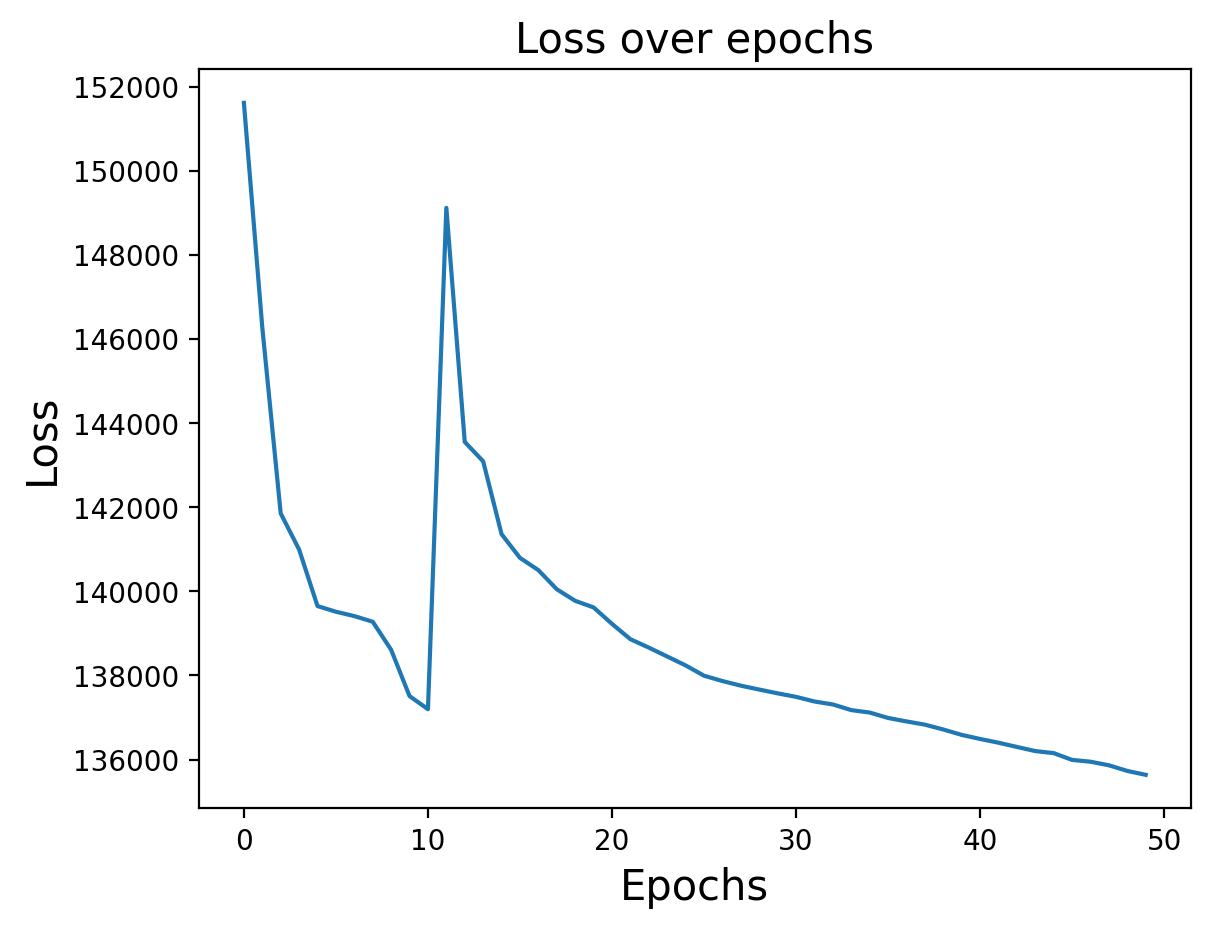

In [27]:
plt.plot(loss_list)
plt.xlabel('Epochs',fontsize =15)
plt.ylabel('Loss', fontsize = 15)
plt.title('Loss over epochs',fontsize = 15)

<Figure size 1280x960 with 0 Axes>

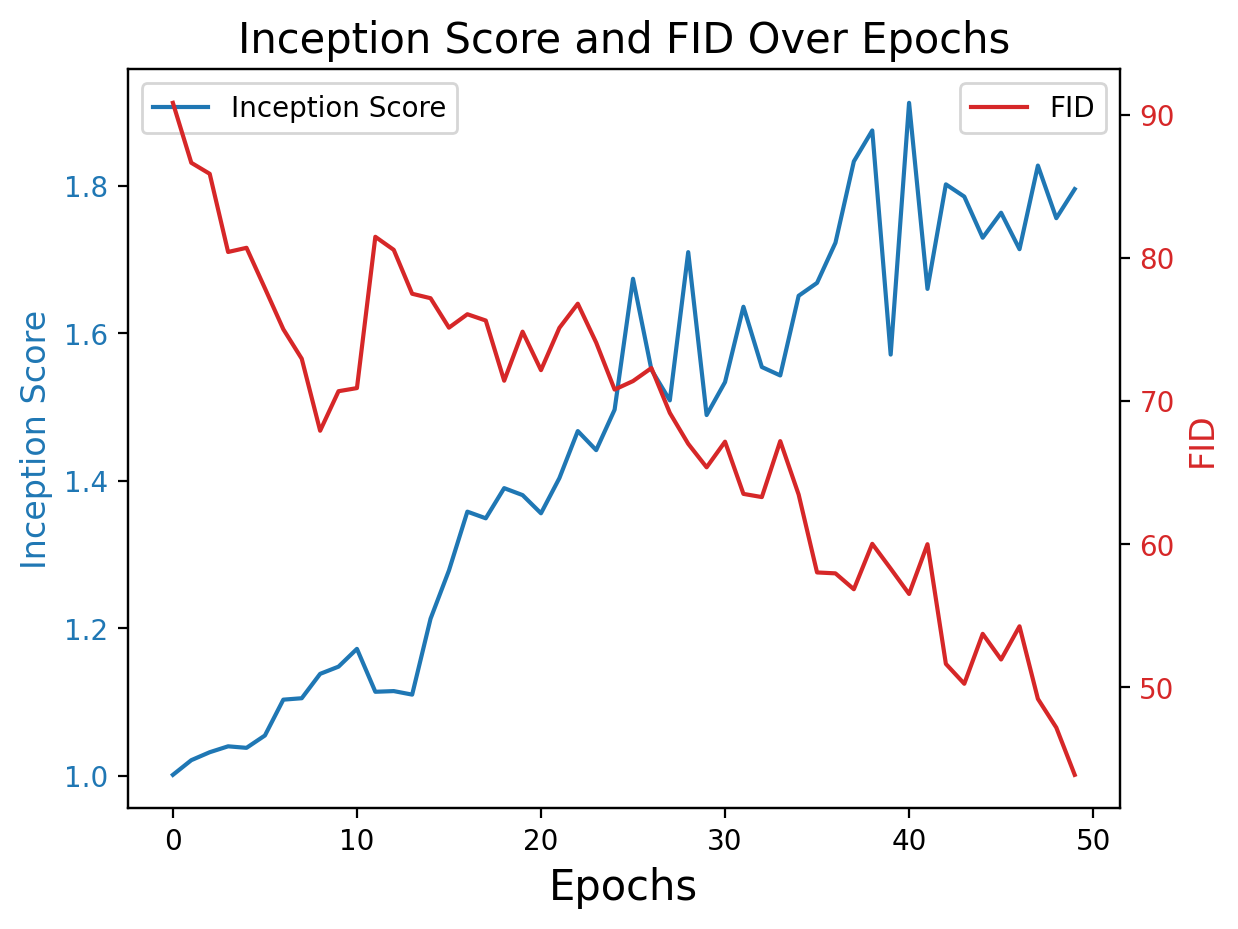

In [28]:
# Create a new figure
plt.figure()

# Plot Inception Score on the left y-axis
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epochs', fontsize=15)
ax1.set_ylabel('Inception Score', color=color, fontsize=12)
ax1.plot(is_values, color=color, label='Inception Score')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for FID
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
color = 'tab:red'
ax2.set_ylabel('FID', color=color, fontsize=12)  # Set label for FID
ax2.plot(fid_values, color=color, label='FID')
ax2.tick_params(axis='y', labelcolor=color)

# Set legends for both plots
ax1.legend(loc='upper left')  # Inception Score legend
ax2.legend(loc='upper right')  # FID legend

# Show the plot
plt.title('Inception Score and FID Over Epochs', fontsize=15)
plt.show()


In [29]:
num_generated_images = 64
generated_images = model.generate_images(num_generated_images)

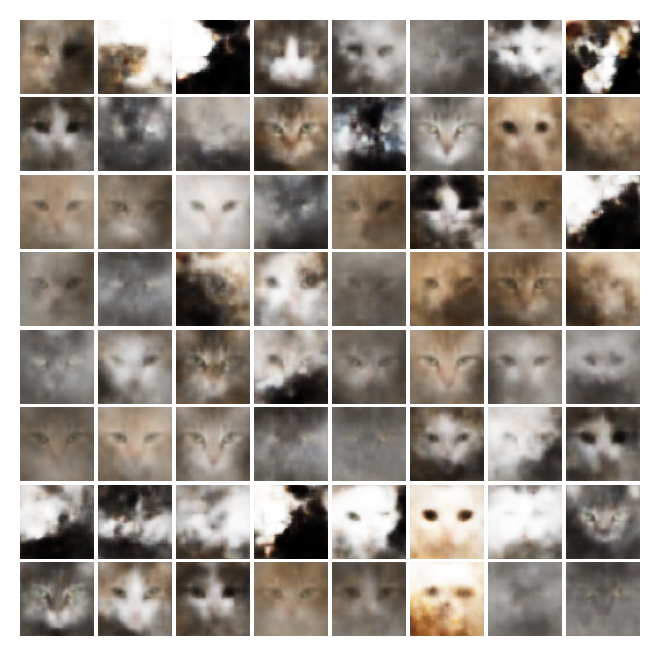

In [30]:
# Convert generated images tensor to numpy arrays
generated_images_np = generated_images.cpu().detach().numpy()# Generated from new vector
#generated_images_np = decoded.cpu().detach().numpy()    # Generated from training input

# Set the number of columns for subplots
num_columns = 8

# Calculate the number of rows needed based on the number of generated images and number of columns
num_rows = (num_generated_images + num_columns - 1) // num_columns

# Create a new figure for displaying subplots
plt.figure(figsize=(4,4))

# Iterate through each generated image
for i in range(num_generated_images):
    # Access the ith generated image
    #generated_image_np = generated_images_np[i] # Generated from new vector
    generated_image_np = np.transpose(generated_images_np[i], (1, 2, 0))   # Generated from training input

    # Visualize the image in the corresponding subplot
    plt.subplot(num_rows, num_columns, i + 1)

    #plt.imshow(generated_image_np.transpose(1, 2, 0))  # Transpose to (height, width, channels) for visualization
    plt.imshow(generated_image_np)
    plt.axis('off')  # Turn off axis

# Adjust layout to prevent overlap

plt.subplots_adjust(wspace=0.05, hspace=0.05)
# Show the figure with subplots
plt.show()